In [1]:
import cv2
import sys
sys.path.append("../")
import anchors
import data
from matplotlib import pyplot as plt
import numpy as np
import pickle
import matplotlib
%matplotlib notebook

In [2]:
norm = True
data_train = pickle.load(file = open('../wider_train.p', 'rb'))
svc = data.DataService(data_train, False, '../../WIDER/train_images/', (1024, 1024)
                      ,normalised = norm)
CONFIG = [[1024, 1024, 32, 32, 32, 32, 4], 
          [1024, 1024, 32, 32, 64, 64, 2],
          [1024, 1024, 32, 32, 128, 128, 1],
          [1024, 1024, 64, 64, 256, 256, 1],
          [1024, 1024, 128, 128, 512, 512, 1]] 
boxes_vec, boxes_lst, stubs = anchors.get_boxes(CONFIG, norm)

In [3]:
def print_image(img_in, boxes, normalised = norm, anchors = None):
    img = img_in.copy()
    plt.figure()
    h, w, _ = img.shape
    for box in boxes:
        if normalised:
            cv2.rectangle(img, (int(box[0]*w),int(box[1]*h)), (int(box[2]*w), int(box[3]*h)), (0,255,0), 3)                
        else:
            cv2.rectangle(img, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), (0,255,0), 3)
    if anchors is not None:
        for box in anchors:
            if normalised:
                cv2.rectangle(img, (int(box[0]*w),int(box[1]*h)), (int(box[2]*w), int(box[3]*h)), (255,0,0), 3)                
            else:
                cv2.rectangle(img, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), (255,0,0), 3)                
    plt.imshow(img)
    plt.show()

### Test encode

<IPython.core.display.Javascript object>


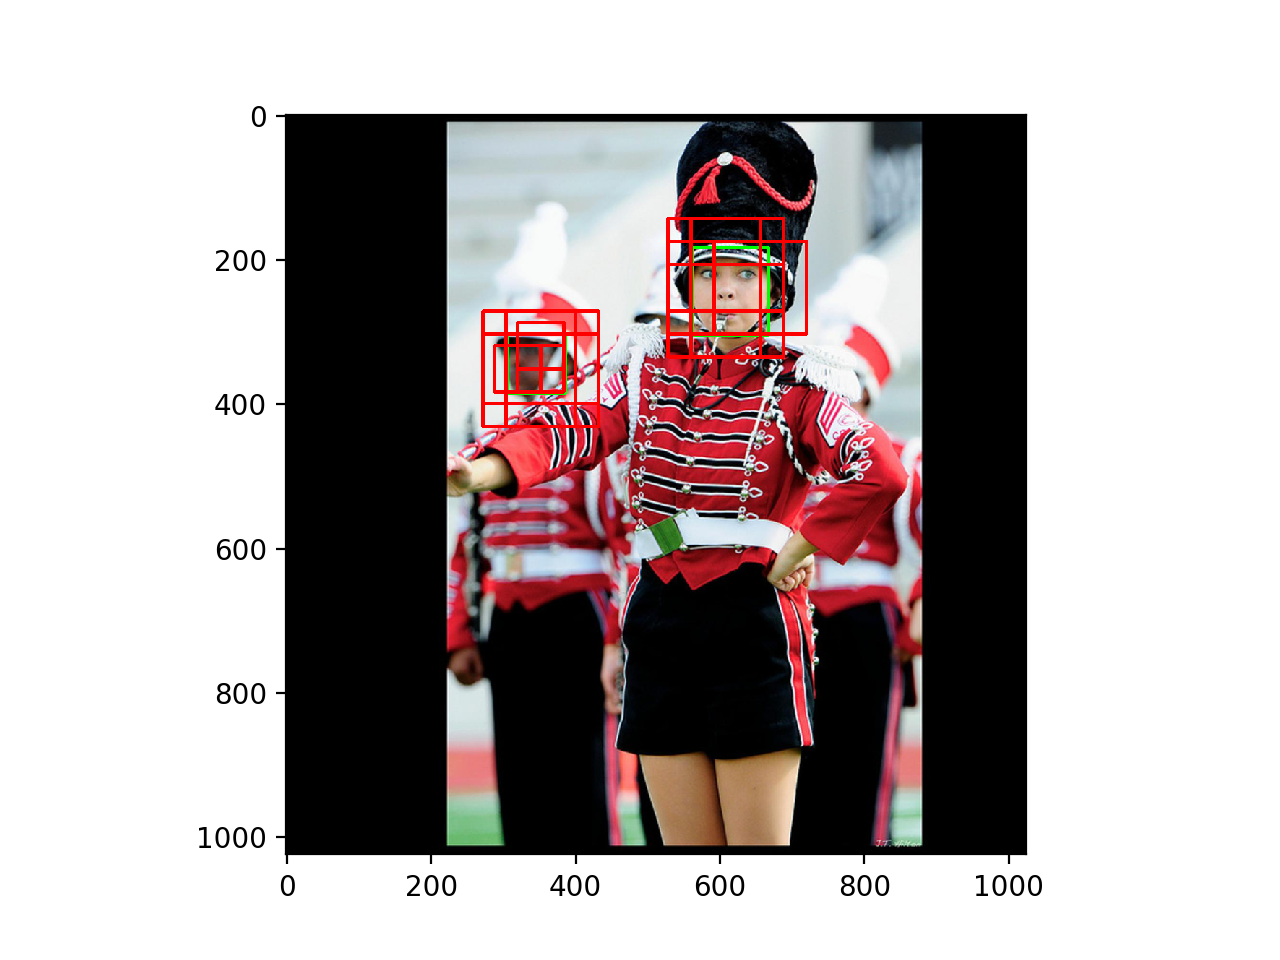

In [5]:
i = 223
img = svc.read_image(data_train[i]['file_path'])
boxes = [data_train[i]['bbox']]
imgs, boxes = svc.resize_images([img], boxes)
if norm:
    boxes = [i/np.tile((1024, 1024), 2) for i in boxes]
locs, confs_o = anchors.encode(boxes_vec, boxes[0], threshold = 0.35)
confs = np.eye(2)[confs_o.astype(int)]
boxes_preds, _, _ = anchors.decode(boxes_vec, locs, confs, do_nms = True)
test_loc, test_confs, test_anchors = pickle.load(file=open('../check.pickle', 'rb'))
t_confs = np.eye(2)[test_confs.astype(int)]
test_anchors = np.concatenate((test_anchors[:, :2], test_anchors[:, :2] + test_anchors[:, 2:]), axis = -1)
test_preds, _, _ = anchors.decode(test_anchors, test_loc, t_confs, do_nms = True)
# print(test_loc[test_confs == 1])
# print(locs[confs_o == 1])
# print('######')
# print_image(imgs[0], boxes[0], anchors = boxes_vec[np.squeeze(np.argwhere(confs_o == 1)), :])
print_image(imgs[0], boxes_preds,  anchors = boxes_vec[np.squeeze(np.argwhere(confs_o == 1)), :])
# print_image(imgs[0], test_preds,  anchors = test_anchors[np.squeeze(np.argwhere(test_confs == 1)), :])

## Encode/Decode Test

mAP:  0.9877450980392157
(12, 4)


<IPython.core.display.Javascript object>


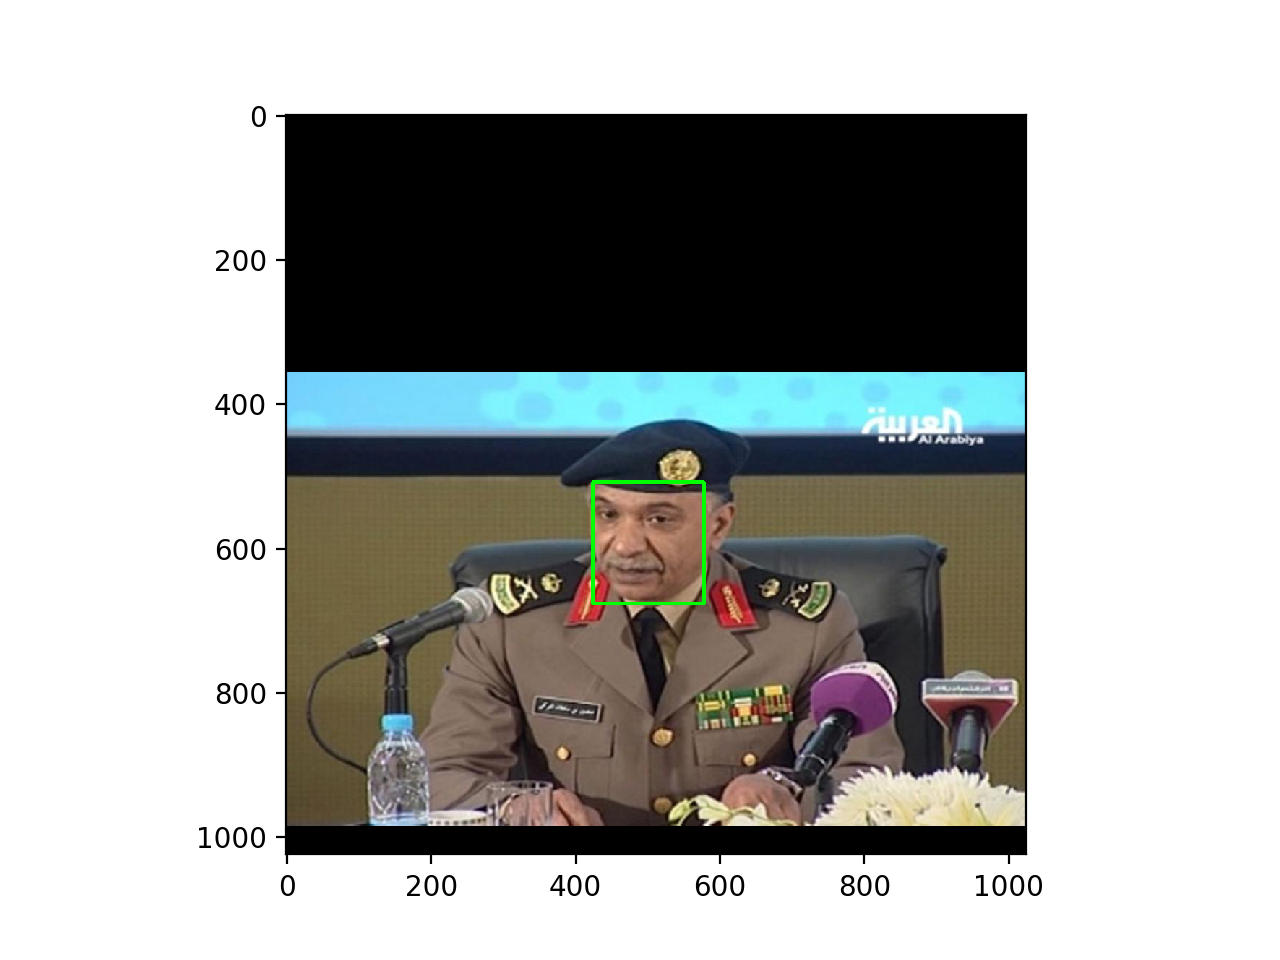

<IPython.core.display.Javascript object>


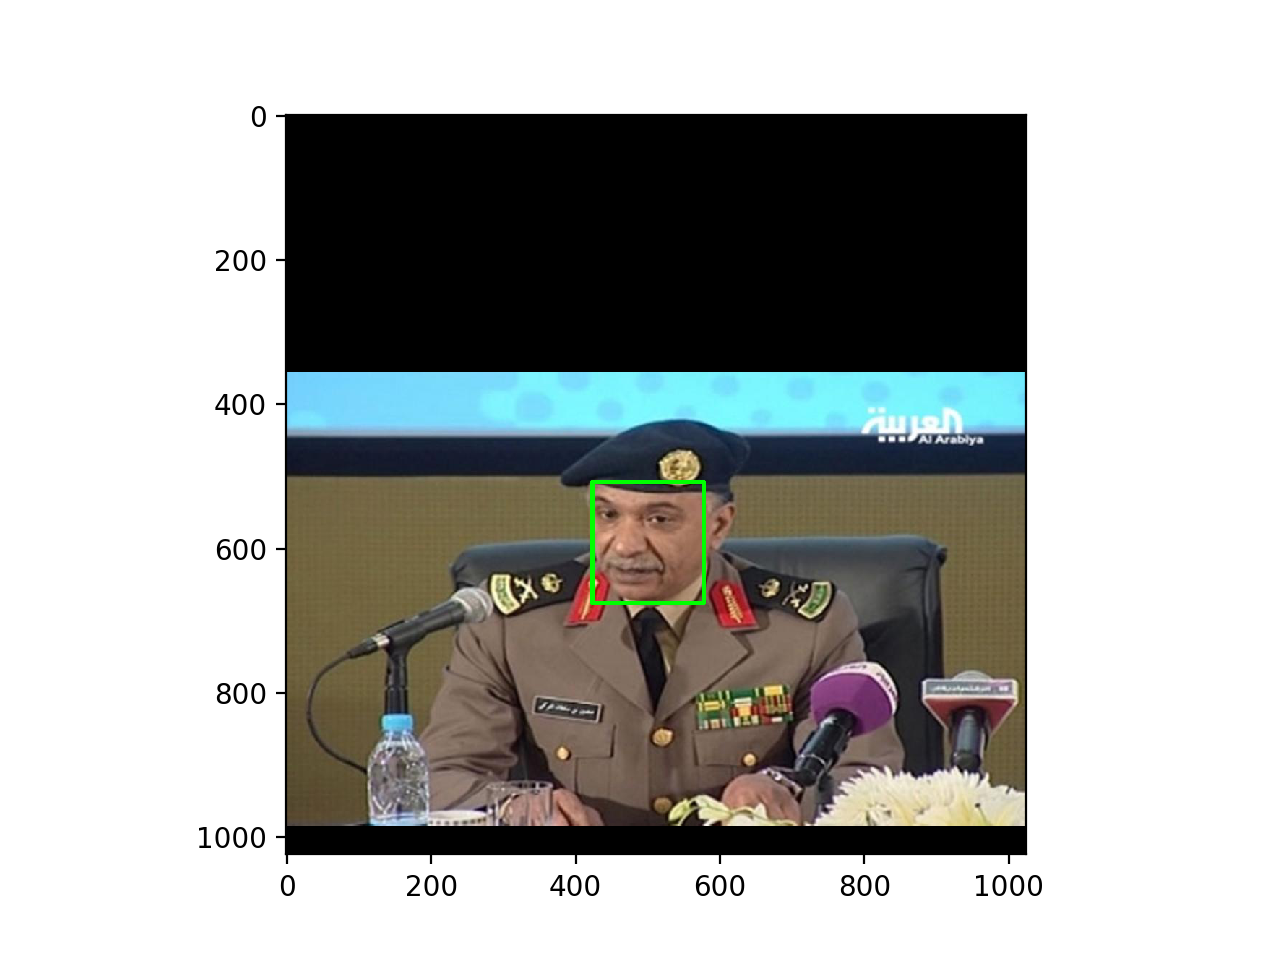

In [6]:
imgs, lbls = svc.random_sample(5)
i = 4
locs, confs_o = anchors.encode(boxes_vec, lbls[i], threshold = 0.35)
# locs[confs_o==1] = np.random.uniform(-5, 5, locs[confs_o==1].shape)
confs = np.eye(2)[confs_o.astype(int)]
boxes_preds, _, _ = anchors.decode(boxes_vec, locs, confs, do_nms = False)
print('mAP: ', anchors.compute_mAP([imgs[i]], [lbls[i]], [boxes_preds],normalised = norm))
print(locs[confs_o == 1].shape)
print_image(imgs[i], lbls[i])
print_image(imgs[i], boxes_preds)